In [1]:
import h5py as h5
import PreFRBLE
from PreFRBLE.likelihood import *
from PreFRBLE.convenience import *
from PreFRBLE.plot import *

Simulations show that at $z \gtrsim 1.5$ about 90 % of baryons were contained in the IGM (Meiskin 2008, 0711.3358). Here we check how much results for a linear evolution of $f_{\rm IGM}$ between redshifts $z=1.5$ and $z=0$ (solid) would differ from constant $f_{\rm IGM}$ (dotted). The right plot shows the ratio of the two graphs.

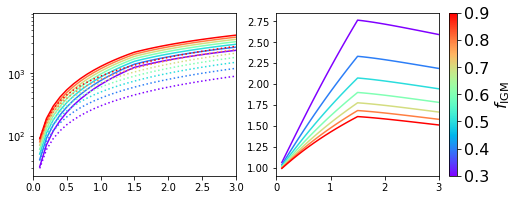

In [102]:

zs = np.linspace(0.1,6,60)
ps = np.arange(0.5,1.1,0.1)[::2]
p = 1
f_IGM0s = np.arange( 0.3,1.0,0.1 )

fig, axs = plt.subplots(1,2, figsize=(8,3))

for f_IGM0, color in zip( f_IGM0s, Rainbow(f_IGM0s) ):
    f_IGMs = f_IGM0 + np.where( zs<1.5, zs, 1.5)/1.5 * 0.50
    DMs = [ DM(z, f_IGM=f_IGM) for z, f_IGM in zip( zs, f_IGMs ) ]
    axs[1].plot(zs, DMs/(zs*1000*f_IGM0), color=color)
    axs[0].plot(zs, DMs, color=color)
    axs[0].plot( zs, zs*1000*f_IGM0, color=color, linestyle=":")
for ax in axs:
    ax.set_xlim(0,3)
axs[0].set_yscale('log')
Colorbar( f_IGM0s, label=r"$f_{\rm IGM}$" )


#### wipe all entries of a scenario

In [20]:
from time import sleep
import h5py as h5

scenario={ 
    'IGM':['alpha1-3rd_C300'], 
    'Host':['Rodrigues18'], 
    'Local':['Piro18/wind'] 
}

KeyFull( measure='RM', axis='', redshift=1., **scenario )


with h5.File( '/hummel/PreFRBLE/likelihood/observables_likelihood_Full.h5' ) as f:
#    for B in [1,2,3,4,5,6,7,8,9]: 
    f.__delitem__( "/alpha2-3rd_C300/Rodrigues18/Piro18/wind/1.3/RM" )
    for B in [2,6]: 
        for F in [3,4,5,6,7,8,9]: 
            tmp = scenario.copy()
            tmp['IGM'] = ['alpha{0}-3rd_C{1}00'.format(B,F)], 
            for z in redshift_bins: 
                key = KeyFull( measure='RM', axis='', redshift=z, **tmp )
                print( f[key] )
                try:
                    print( f[key].keys(), end=' ' )
                    print( key )
#                    f.__delitem__( key )
                except:
                    pass
                sleep(5e-3)

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  del sys.path[0]


KeyError: "Couldn't delete link (bad symbol table node signature)"

#### Recover HDF5 file with broken nodes

In [1]:
file_broken = '/hummel/PreFRBLE/likelihood/observables_likelihood_Full.h5'
file_recover = '/hummel/PreFRBLE/likelihood/observables_likelihood_Full_recover.h5'

import h5py as h5

def RecoverFile( f1, f2 ):
    """  recover read-open HDF5 file f1 to write-open HDF5 file f2  """
    names = []
    f1.visit(names.append)
    for n in names:
        try:
            f2.create_dataset( n, data=f1[n][()] )
        except:
            pass

        

In [ ]:
with h5.File( file_broken, 'r' ) as fb:
    with h5.File( file_recover, 'w' ) as fr:
        for key in fb.keys():
            try:
                fr.create_group(key)
                RecoverFile( fb[key], fr[key] )
            except:
                fr.__delitem__(key)
        
        

In [ ]:
VisitFile(file_broken)

In [12]:
def VisitFile( filename ):
    """ print keys and shape for all array datasets in hdf5-file """
    with h5.File(filename, 'r') as f:
        print(f.keys())
        names = []
        f.visit(names.append)
        for n in names:
            try: print(n, f[n][()].shape)
            except: pass

### test Convolution

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


0.9999999999999999


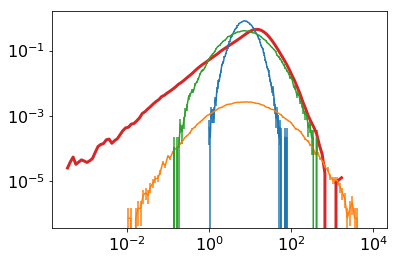

In [48]:
N = 100000 ## sample size
bins = 100
absolute=True
norm=0.01

## ranges for dummy functions
f = np.array([0,2]) 
g = np.array([-2,4])
h = np.array([-1,3])


## sample log-normal distribution
fs = np.random.lognormal( mean=2*np.mean(f), sigma=np.std(f)/2, size=N )
gs = np.random.lognormal( mean=2*np.mean(g), sigma=np.std(g)/2, size=N )
hs = np.random.lognormal( mean=2*np.mean(h), sigma=np.std(h)/2, size=N )

## likelihood function and deviation of samples f & g
P_f = Likelihood( fs, log=True, density=True, range=10.**f, bins=bins )
P_f = list(P_f)
P_f.append( LikelihoodDeviation( *P_f, N=N ) )

P_g = Likelihood( gs, log=True, density=True, range=10.**g, bins=bins )
P_g = list(P_g)
P_g.append( LikelihoodDeviation( *P_g, N=N ) )

P_h = Likelihood( hs, log=True, density=True, range=10.**h, bins=bins )
P_h = list(P_h)
P_h.append( LikelihoodDeviation( *P_h, N=N ) )


P_g[0] *= norm




P_con = LikelihoodsConvolve( P_f, P_g, P_h , log=True, absolute=absolute, N=N, smooth=True )
print(LikelihoodNorm(*P_con))
fig, ax = plt.subplots()

PlotLikelihood( *P_f , density=True, ax=ax)
PlotLikelihood( *P_g , density=True, ax=ax)
PlotLikelihood( *P_h , density=True, ax=ax)
PlotLikelihood( *P_con[:-1] , density=True, ax=ax, lw=3, cumulative=0)


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


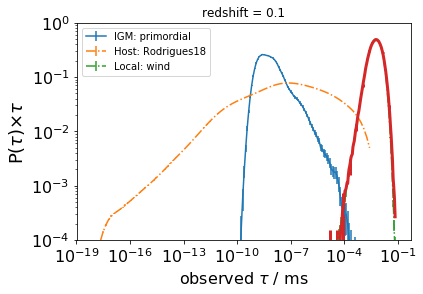

In [20]:
import h5py as h5
import PreFRBLE
from PreFRBLE.likelihood import *
from PreFRBLE.convenience import *
from PreFRBLE.plot import *

scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
#    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
#    'N_inter' : True
}

measure = 'tau'
redshift = 0.1

fig, ax = plt.subplots()

PlotContributions( dev=True, measure=measure, redshift=redshift, ax=ax, **scenario )
P = LikelihoodFull( dev=True, measure=measure, redshift=redshift, progress_bar=True, **scenario)
PlotLikelihood( *P, ax=ax, lw=3, errorevery=10 )

ax.set_ylim(1e-4,1)
plt.show()

In [1]:
### place in top of likelihood.py, remove following line
from PreFRBLE.likelihood import *






from sys import exit

from PreFRBLE.label import *
from PreFRBLE.convenience import *
from PreFRBLE.file_system import *


likelihood_files = {
    'IGM' : likelihood_file_IGM,
    'Local' : likelihood_file_Local,
    'Host' : likelihood_file_Host,
    'Inter' : likelihood_file_Inter,
    'inter' : likelihood_file_inter,
    'redshift' : likelihood_file_redshift,
    'Full' : likelihood_file_Full,
    'telescope' : likelihood_file_Telescope,
}

label_likelihood = {
    'likelihood' : 'L',
    'prior' : r"$\pi$",
    'posterior' : "P"
}

cum_sign = {
    0 : '',
    1 : '<',
    -1: '>'    
}

class LikelihoodFunction:
    """
    class for likelihood functions P(x). P is the probability density function within range givn by x
    
    """
    def __init__(self, P=[], x=[], dev=[], scenario=False, measure='', region='', redshift=0.0, log=True, typ='likelihood'):
        ## core properties
        self.P = np.array(P)        ## probability density function
        self.x = np.array(x)        ## range of bins
        self.dev = np.array(dev)    ## relative deviation of P
        
        ## identifier. Required tfor use of file system to read/write likelihood functions
        self.scenario = scenario    ## scenario described by P
        self.region = region        ## region considered for P
#        self.redshift = redshift    ## host redshift   ## is stored in scenario, likewise to telescope and population
        self.log = log              ## x is log-scale?
        
        ## critical 
        if measure not in label_measure.keys():
            exit( "please provide a valid measure, {}".format( list( label_measure.keys() ) ) )
        self.measure = measure      ## measure whose likelhood is quantified by P
        if not typ in label_likelihood.keys():
            exit( "invalid type of likelihood function: {}".format( list(label_likelihood.keys()) ) )
        self.typ = typ              ## type of likelihood: likelihood, prior or posterior
    
    ## useful derived values
    
    def dx(self):
        """ returns width of bins in x """
        return np.diff(self.x)
    
    def x_central(self):
        """ returns central value for x bins """
        if self.log: self.x = np.log10( self.x ) ## for log-scaled values, use logarithmic center
        res = self.x[:-1] + self.dx()/2
        if self.log: 
            self.x = 10.**self.x        ## undo changes to x 
            res = 10.**res
        return res
        
    def Probability(self):
        return self.P*self.dx()
        
    def Norm(self):
        """ return norm of likelihood function """
        return np.sum(self.Probability())
    
    def Cumulative(self, direction=1 ):
        P = np.cumsum( self.Probability() )
        if direction == -1:
            P = 1 - P
        return P


    ## modify likelihood function
    
    def Renormalize(self, norm=1 ):
        """ renormalize the entire likelihood function to norm """
        self.P = self.P * norm / self.Norm()
        
    def Shift(self, shift=1. ):
        """ Shift x-values of likelihood function and renormalize accordingly: P'(x|shift) = shift * P(shift*x|1) """
        # x' = shift*x, thus P' = P dx/dx' = P / shift
        self.P = self.P/shift
        self.x = self.x*shift
        
    def Smooth(self, mode='MovingAverage' ):
        """
        Smooth likelihood function

        modes available:
            MovingAverage : smooth using moving average over 5 neighbouring boxes
        """

        norm = self.Norm()

        if mode == 'MovingAverage':
            box_pts = 5
            self.P = np.convolve( self.P, np.ones(box_pts)/box_pts, mode='same' )

        ## smoothing doesn't conserve normalization
        self.Renormalize( norm )
        
    def Deviation(self, N=1 ):
        """ compute relative deviation (Poisson noise) of likelihood function of individual model obtained from sample of N events """
        self.dev =  ( P*np.diff(x)*N )**-0.5
        self.dev[ np.isinf(self.dev) + np.isnan(self.dev)] = 0
        

    
    def Shrink(self, bins=100, renormalize=False, **kwargs_LikelihoodsAdd ):  ### !!! test after LikelihoodsAdd is modified
        """ reduce number of bins in likelihood function, contains normalization """
        ### Actual work is done by LikelihoodsAdd, which adds up several P to new range with limited number of bins                                          
        ### to shrink function, add P=0 with identical range
        
        dummy = LikelihoodFunction( P=np.zeros(len(self.P)), x=self.x, dev=np.zeros(len(self.dev)) if len(self.dev) > 0 else [], measure=self.measure )
        renorm = renormalize if renormalize else self.Norm()
        return LikelihoodsAdd( self, dummy, shrink=bins, log=self.log, renormalize=renorm, **kwargs_LikelihoodsAdd )


        
    def Measureable( min=None, max=None ):   ### !!! test after LikelihoodsAdd is modified
        """    returns the renormalized part of full likelihood function that can be measured by telescopes, i. e. min <= x <= max """
        ## determine number of bins in result, roughly number of bins  min <= x <= max                                                                                                                                                                                                                                 
        bins = int(np.sum( np.prod( [self.x>=min if min else np.ones(len(sel.fx)), self.x<=max if max else np.ones(len(self.x)) ], axis=0 ) ))
        self.Shrink( min=min, max=max, renormalize=1, bins=bins, smooth=False ) ### smoothing is not reliable at border values. Here, border value is close to peak in P, hence don't smooth

        
    ## hard drive handler ### !!!! finish this section
        
    def Read(self): 
        """ read likelihood function from file. Only requires to define scenario and region """
        with h5.File( self.scenario.File() ) as f:
            L_read = f[self.scenario.Key()][()]  ## LikelihoodFunction object written to file
            ### decorate self with all properties of L
            ### self = L_read ???
        
        pass
        
    def Write(self):
        """ write likelihood function to file (defined by region) with key (defined by scenario) """
        if self.typ in ['prior' or 'posterior']:
            exit( "We do not write priors or posteriors to file")
        if self.scenario == {}:
            exit( "please provide a scenario to define where to write" )
            
        ## write to file
        Write2h5( self.scenario.File(), datas=[self], keys=[self.scenario.Key()] ) # region=region, measure=measure, redshift=redshift, **self.scenario)] )
        pass
        
    
    ## convenient procedures
        
    def Plot(self, cumulative=0, density=True, probability=False, ax=None, **kwargs):
        """
        Plot likelihood function P(x) of measure
            
        Parameters
        ----------
        cumulative : boolean, 1, -1
            if 1: plot cumulative likelihood starting from lowest x
            if -1: plot cumulative likelihood starting from highest x
            else: plot differential likelihood
        density : boolean
            indicates whether to plot density
        probability : boolean
            indicates whether to plot probability
        measure : string
            name of measure x
        **kwargs :  for plt.plot ( or plt.errorbar, if dev is not None )
        """
        if ax is None:
            fig, ax = plt.subplots( )
            
        if cumulative:
            P = self.Cumulative( cumulative )
        elif probability:
            P = self.Probability()
        elif density:
            P = self.P
        else: ## this is used for better interpretation of pdf of log-scaled values
            P = self.P*self.x_central() ### value is physical and not influenced by binsize, while shape equals probability in bin 


        if len(self.dev):
            ax.errorbar( self.x_central(), P, yerr=self.dev*P, **kwargs  )
        else:
            ax.plot( self.x_central(), P, **kwargs)

        ax.set_xlabel( UnitLabel( self.measure ) , fontdict={'size':16 } )
        ylabel = ( r"{}({}{})".format( label_likelihood[self.typ], cum_sign[cumulative], label_measure[self.measure] ) )
        if not cumulative:
            if not density:
                ylabel += r"$\times{}${}".format( r"\Delta" if probability else "", label_measure[self.measure] )
            
        ax.set_ylabel( ylabel, fontdict={'size':18 } )
        ax.tick_params(axis='both', which='major', labelsize=16)

        
        
    def Likelihoods(self, measurements=[], minimal_likelihood=0., density=True, deviation=False ):
        """                                                                                                                                                                                                                                                                                                            
        returns likelihoods for given measurements 
                                                                                                                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                                                                                   
        Parameters                                                                                                                                                                                                                                                                                                     
        ---------                                                                                                                                                                                                                                                                                                      
        measurements : array_like                                                                                                                                                                                                                                                                                      
            measurements for which the likelihood shall be returned                                                                                                                                                                                                                                                    
        minimal_likelihood : float                                                                                                                                                                                                                                                                                     
            value returned in case that measurement is outside x                                                                                                                                                                                                                                                       
        density : boolean                                                                                                                                                                                                                                                                                              
            if True, return probability density ( P ) instead of probability ( P*dx )
        deviation : boolean
            if True, return deviations of likelihoods
            
        Returns
        -------
        likelihoods : numpy array, shape( len(measurements) )
            likelihood of measurements = value of P*dx for bin, where measurement is found
        deviations : numpy array, shape( len(measurements) )
            deviations of likelihoods according to dev
        """

        likelihoods = np.zeros( len( measurements ) ) ## collector for likelihoods of measurements
        deviations = likelihoods.copy()
        prob = self.P if density else self.Probability()  ## probability for obtaining measure from within bin
        isort = np.argsort( measurements )   ## sorted order of measurements
        i = 0  ## marker for current bin
        
        ## for each measurement (in ascending order)
        for m, i_s in zip( np.array(measurements)[isort], isort ):
        ##   check bins >= previous results
            for xi in self.x[i:]:
        ##      whether measure is inside
                if m >= xi:  ## measure is bigger than current bin range
                    ##   set marker and continue with next bin
                    i += 1
                    continue
                else:        ## otherwise, measure is in the bin
                    ## put result in correct place and stop checking bins
                    likelihoods[i_s] = prob[i-1]  if i > 0 else minimal_likelihood  ## if that was the lowest bound, probability is ->zero if measurement is outside the range of P, i. e. P~0
                    if len(self.dev):
                        deviations[i_s] = self.dev[i-1] if i > 0 else 1
                    break    ## continue with the next measurement
            else:
                ## if measure is bigger than the last bin
                likelihoods[i_s] = minimal_likelihood  ## probability is zero if measurement is outside the range of P, i. e. P~0
                if len(self.dev):
                    deviations[i_s] = 1

    #    likelihoods = np.array( likelihoods )
        if len(self.dev) and deviation:
            return likelihoods, deviations
        else:
            return likelihoods

        
    def RandomSample(self, N=1 ):
        """                                                                                                                                                                                                                                                                                                            
        returns sample of size N according to likelihood function P(x)

        Parameter
        ---------
        P, x : array-like
            renormalized probability density function, i. e. sum(P*np.diff(x))=1

        Output
        ------

        res : list of N values, distributed according to P(x)

        """
        ## keep original norm for later
        norm = self.Norm()

        ## renormalize to find 1 at most likely value, thus to reject minimum amount of candidates
        f = self.Probability().max()
        self.Renormalize( norm/f )
        lo, hi = self.x[0], self.x[-1]
        if self.log:
            lo, hi = np.log10( [lo,hi] )
            
        res = []
        while len(res) < N:
            ## create random uniform sample in the desired range
            r = np.random.uniform( high=hi, low=lo, size=N )
            if self.log:
                r = 10.**r
            ## randomly reject candiates with chance = 1 - P, in order to recreate P
            z = np.random.uniform( size=N )
            ## obtain probability for bins where measures are found
            p = self.Likelihoods( r, density=False ) ### renormalize pdf to maximum value of probability, i. e. values at maximum probability are never rejected. This minimizes the number of rejected random draws
            res.extend( r[ np.where( z < p )[0] ] )
            
        ## restore original norm
        self.Renormalize( norm )
        return res[:N]
        

    def Expectation(self, sigma=1, std_nan=np.nan ):
        """
        computes the estimate value and deviation from likelihood function P (must be normalized to 1)


        Parameters
        --------
        sigma : integer
            indicates the sigma range to be returned. must be contained in sigma_probability in physics.py                                                                                                                                                                                                             
        std_nan
            value returned in case that P=0 everywhere. if not NaN, should reflect upper limit

        Returns
        -------
        expect: float
            expectation value of likelihood function
        deviation: numpy_array, shape(1,2)
            lower and uppper bound of sigma standard deviation width
            is given such to easily work with plt.errorbar( 1, expect, deviation )   
                                                                                                                                                                                                                                                                                                                   
        """
        x_ = self.x_central()
        if self.log:
            x_ = np.log10(x_)
        P_ = self.Probability()

        ## mean is probabilty weighted sum of possible values
        estimate = np.sum( x_*P_ )
        if self.log:
            expect = 10.**estimate

        ## exactly compute sigma range
        P_cum = self.Cumulative()
        ## find where half of remaining probability 1-P(sigma) is entailed in x <= x_lo
        lo =   expect - first( zip(self.x, P_cum), condition= lambda k: k[1] > 0.5*(1-sigma_probability[sigma]) )[0]
        ## find where half of remaining probability 1-P(sigma) is entailed in x >= x_hi
        hi = - expect + first( zip(self.x[1:], P_cum), condition= lambda k: k[1] > 1- 0.5*(1-sigma_probability[sigma]) )[0]

        deviation = np.array([lo,hi]).reshape([2,1])

        return expect, deviation

    

    
    
        

In [46]:
5%2

1

In [2]:
class Scenario:
    """ 
    class object to define a physical scenario. 
    Either full LoS or individual model
    For individual host redshift or as expected to be observed by telescope, assuming redshift population
    """
    def __init__(self, IGM=[], Local=[], Host=[], Inter=[], inter=[], measure=False, redshift=False, L0=False, N_inter=False, telescope=False, population=False):

        ### !!! include CorrectScenario
        
        ## required parameter for unique identification
        if (redshift and (telescope or population) ) or not ( redshift or (telescope and population)):
            exit( "scenario requires either individual redshift or, both, telescope and redshift population" )
        if not measure:
            exit( "scenario requires a measure, in order to use correct models" )
                        
        self.redshift = redshift
        self.telescope = telescope
        self.population = population
        self.measure = measure


        
        ## optional paramter
        self.L0 = L0
        self.N_inter = N_inter
        
        ## regions
        self.regions = {}
#        self.IGM, self.Local, self.Host, self.Inter, self.inter = [[]]*5
        if IGM: self.regions['IGM'] = [IGM] if type(IGM) is str else IGM
        if Local: self.regions['Local'] = [Local] if type(Local) is str else Local
        if Host: self.regions['Host'] = [Host] if type(Host) is str else Host
        if Inter: self.regions['Inter'] = [Inter] if type(Inter) is str else Inter
        if inter: self.regions['inter'] = [inter] if type(inter) is str else inter
            
        self.CorrectScenario()
        
    def CorrectScenario(self):
        """ 
        this function is used to correct scenario keys wenn reading data,
        since some models have output stored under different name, 
        as some models changes do not affect all measures 
        """
    
        ## different alpha in IGM only affects RM, not DM, SM or tau
        if 'IGM' in self.regions.keys():
            if not 'RM' in self.measure:
                if 'alpha' in self.regions['IGM'][0]:
                    self.regions['IGM'][0] = self.regions['IGM'][0].replace( scenario['IGM'][0][:10], 'primordial' )  ### !! single IGM model in use is hardcoded, change this to compare different IGM models
            else: ## however, RM is only saved for alpha
                pass
                if 'primordial' in self.regions['IGM'][0]:
                    self.regions['IGM'][0] = self.regions['IGM'][0].replace( 'primordial', 'alpha1-3rd' )  ### !! single IGM model in use is hardcoded, change this to compare different IGM models
            
    def File(self):
        """ find correct likelihood likelihood file corresponding to given scenario parameters  """
        if not redshift: ## no redshift means we assume a redshift distribution, thus either show expected observation of given model or redshift distribution if no model is given
            key = 'telescope' if len(self.regions) else 'redshift'
        elif len( self.regions ) > 1: ## several models combine to full LoS scenario
            key = 'Full'
        else: ## raw likelihood of single model is found in individual file
            key = list( self.regions.keys() )[0]
        return likelihood_files[key]
    
    def Key(self):
        """ return key used to save scenario in likelihood file """
        if not self.measure:
            exit( "Key requires measure, which is not part of Scenario" )
        
        key_elements = []
        
        if self.telescope:
            key_elements.extend( [self.telescope, self.population] )
        else:
            key_elements.append( str(np.round(self.redshift,1)) )
        for region in np.sort( list( self.regions.keys() ) ):
            key_elements.append( '_'.join( self.regions[region] ) ) ## combine all models assumed for each region (e. g. to allow consideration of multiple source environments)
            
            if region == 'Inter': ## in order to distinguish between intervening and host galaxies, which may use the same model
                key_elements[-1] += '_{}Inter'.format( 'N' if self.N_inter else '' )
            elif region == 'IGM' and self.measure == 'tau' and self.L0:  ## tau depends on L0, which can be changed in post-processing
                key_elements[-1] += '_L0{:.0f}kpc'.format( L0 )  ### initially computed assuming L0 = 1 Mpc
            
        key_elements.append( self.measure )
        
        return '/'.join( key_elements)
        

In [4]:
telescope='CHIME'
population='SMD'
redshift=False

telescope, population, redshift = 'CHIME', 'SMD', False
telescope, population, redshift = False, False, 0.1


s = Scenario( measure='DM', Local='Piro18/wind', IGM='primordial',  telescope=telescope, population=population, redshift=redshift)
#s.regions.keys()[0]
s.measure='RM'
s.Key(), s.File()


('0.1/primordial/Piro18/wind/RM',
 '/data/prefrble/PreFRBLE/likelihood/observables_likelihood_Full.h5')

In [85]:
for r in np.sort(list(s.regions.keys())):
    print(r)
    
print(len(s.regions))


Host
IGM
Inter
Local
4


/data/prefrble/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:183: RuntimeWarning: divide by zero encountered in power


<ErrorbarContainer object of 3 artists>

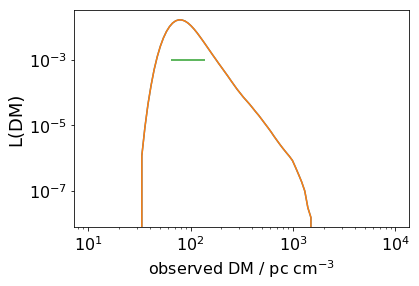

In [38]:

region='IGM'
redshift=0.1
measure='DM'
model='primordial'

P, x = GetLikelihood( region=region, model=model, redshift=redshift, measure=measure )

L = LikelihoodFunction( P=P, x=x, region=region, redshift=redshift, measure=measure, scenario={region:model} )

density=True
fig, ax = plt.subplots()
#L.Plot( ax=ax, density=density )
plt.xscale('log')
plt.yscale('log')
L.Smooth()
L.Plot( ax=ax, density=density )
#L.Shift( 10 )


L.Plot( ax=ax, density=density )
L.Deviation( N=50000)
#L.Plot( ax=ax, density=density )
L.Likelihoods( measurements=[100,200,])

#DMs = L.RandomSample( 1000, log=True)

#LL = Likelihood(DMs, bins=10, log=True, measure=measure )
#LL.Plot( ax=ax, density=density, linestyle='--' )

est, dev = L.Expectation()

ax.errorbar( est, 1e-3, xerr=dev)



#L.Shrink( bins=10 )

#L.Plot( ax=ax, density=density )


[]

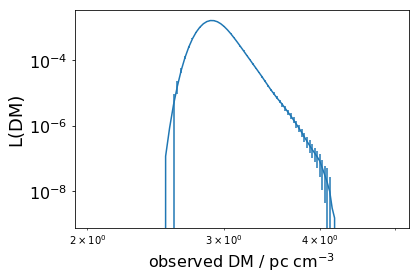

In [34]:
L.Plot()
plt.loglog()